# New York City Taxi Trip Duration

https://www.kaggle.com/c/nyc-taxi-trip-duration/data

Data fields

* **id** - a unique identifier for each trip
* **vendor_id** - a code indicating the provider associated with the trip record
* **pickup_datetime** - date and time when the meter was engaged
* **dropoff_datetime** - date and time when the meter was disengaged
* **passenger_count** - the number of passengers in the vehicle (driver entered value)
* **pickup_longitude** - the longitude where the meter was engaged
* **pickup_latitude** - the latitude where the meter was engaged
* **dropoff_longitude** - the longitude where the meter was disengaged
* **dropoff_latitude** - the latitude where the meter was disengaged
* **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* **trip_duration** - duration of the trip in seconds

#### Warning
You should download train + test

In [145]:
import pandas as pd
import numpy as np

In [149]:
train = pd.read_csv("/home/radoslav/ML/data/nyc-taxi-trip-duration/train.csv")
train.shape

(1458644, 11)

In [150]:
train.head(10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225


In [ ]:
for column in train.columns.values:
    top_result = train[column].value_counts().head(1)
    print("Column {} has max duplicates equal to {}".format(top_result.name,top_result.values[0]))

# Да си поиграем с данните

* duration e точно pickup - dropoff datetime (в тестовите липсва dropoff ;) )
* Ползвам pickup/dropoff координатите, за да измеря дистанцията. 

* Колоната passenger_count може да е полезна ( защо? )

In [173]:
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.data = pd.DataFrame()

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        self.data["vendor_id"] = data_dict["vendor_id"]
        self.data["pcount"] = data_dict["passenger_count"]
        self.data["online"] = data_dict["store_and_fwd_flag"]
        def haversine(lon1, lat1, lon2, lat2):
            """
            Calculate the great circle distance between two points 
            on the earth (specified in decimal degrees).
            Source: https://gis.stackexchange.com/a/56589/15183
            """
            # convert decimal degrees to radians 
            lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
            # haversine formula 
            dlon = lon2 - lon1 
            dlat = lat2 - lat1 
            a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
            c = 2 * math.asin(math.sqrt(a)) 
            km = 6367 * c
            return km * 1000


        self.data["distance"] = data_dict.apply(lambda row : haversine(row["pickup_longitude"],
                             row["pickup_latitude"],
                             row["dropoff_longitude"],
                             row["dropoff_latitude"]), axis=1 )
        return self.data

In [176]:
data = FeatureTransformer().fit_transform(train)
data["duration"] = train["trip_duration"]
data.head(10)

,vendor_id,pcount,online,distance,duration
0,2,1,N,1497.579941,455
1,1,1,N,1804.373590,663
2,2,1,N,6381.089644,2124
3,2,1,N,1484.565760,429
4,2,1,N,1187.842210,435
5,2,6,N,1098.252494,443
6,1,4,N,1325.445880,341
7,2,1,N,5711.392509,1551
8,1,1,N,1309.530584,255
9,2,1,N,5117.946267,1225


В таблицата горе distance е в метри, защото duration е измерено в секунди и м/с е като km/h :)


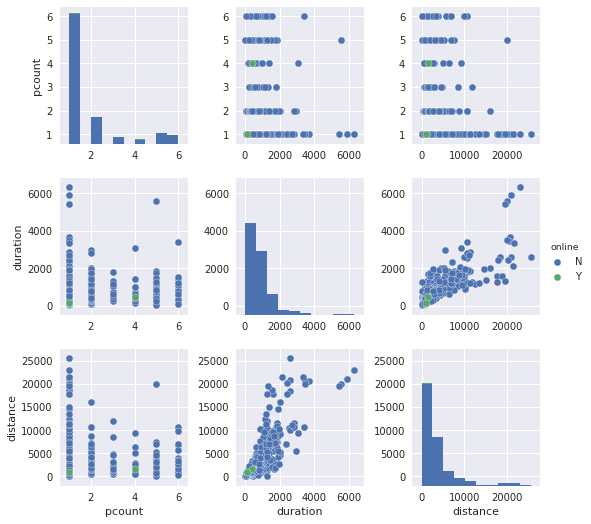

In [177]:
import matplotlib as plt
import seaborn as sns
%matplotlib inline

sns.set()
sns.pairplot(data[ ["pcount", "online", "duration", "distance"] ].sample(n=500, random_state=0), hue="online")

### Размишления по стойностите (За др random_state) ще са различни, но сродни

* **Разглеждам duration x distance**

  Ясно се вижда, че в с нарастване на дистанцията расте и времето за пътуване (нормално).
  Обаче от извадката има и странни случая (при random_state=1 , 26) си личи повече:
  * за малка дистанция времето е голямо (може би е измерване в час пик, спрели са и т.н) (интересно е да проследим колко такива случаи има, може да го направя по-надолу)
  * за голяма дистанция времето е малко: това си го обяснявам лесно, таксито е било фен на https://en.wikipedia.org/wiki/Taxi_(1998_film)
  
* **pcount x distance**
  Забелязвам, че на големи разстояния пътуват най-често по 1-2 човека в кола (сигурно в Ню Йорк такситата са неудобни за много хора :D )
  
  
  
  

### Да поразцъкаме малко модели и магия (LinearRegression, RandomForest, SVR)

Преди това ще трябва да дообработим данните още малко. Ще енкодна online и ще трябва да нормирам данните за SVM-а


In [178]:
def encode_online(data):
    data["on"] = (data["online"] == "Y").astype(float)
    data["off"] = (data["online"] == "N").astype(float)
    return data.drop("online", axis=1)

data = encode_online(data)

data.head(10)

,vendor_id,pcount,distance,duration,on,off
0,2,1,1497.579941,455,0.0,1.0
1,1,1,1804.373590,663,0.0,1.0
2,2,1,6381.089644,2124,0.0,1.0
3,2,1,1484.565760,429,0.0,1.0
4,2,1,1187.842210,435,0.0,1.0
5,2,6,1098.252494,443,0.0,1.0
6,1,4,1325.445880,341,0.0,1.0
7,2,1,5711.392509,1551,0.0,1.0
8,1,1,1309.530584,255,0.0,1.0
9,2,1,5117.946267,1225,0.0,1.0


In [183]:
data.describe()

,vendor_id,pcount,distance,duration,on,off
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,3.438704e+03,9.594923e+02,5.515396e-03,9.944846e-01
std,4.987772e-01,1.314242e+00,4.293840e+03,5.237432e+03,7.406066e-02,7.406066e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,1.231063e+03,3.970000e+02,0.000000e+00,1.000000e+00
50%,2.000000e+00,1.000000e+00,2.092403e+03,6.620000e+02,0.000000e+00,1.000000e+00
75%,2.000000e+00,2.000000e+00,3.872904e+03,1.075000e+03,0.000000e+00,1.000000e+00
max,2.000000e+00,9.000000e+00,1.240130e+06,3.526282e+06,1.000000e+00,1.000000e+00


In [190]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV

clf = []
clf.append( ("LinearRegression", LinearRegression() ))
clf.append( ("Lasso", Lasso()) )
clf.append( ("Ridge", Ridge()) )
# clf.append( ("RandomForest", RandomForestRegressor()) )

# clf.append( ("SVR", SVR()) )     

params = {
    "LinearRegression": [{}],
    "Lasso": [{"alpha": [0.1, 1, 10, 50, 100, 200]}],
    "Ridge": [{"alpha": [0.1, 1, 10, 20, 50, 100]}]
    
#     "SVR": [ {"C": [0.1, 1, 10, 100, 1000], "kernel": ["linear"]},
#              {"C": [0.1, 1, 10, 100, 1000], "gamma": [0.001, 0.0001], "kernel": ["rbf"]}
#            ],
#     "RandomForest": [{"random_state": [26], "n_estimators": [10,100], "max_depth":[20]}]
}


for model_name, model in clf:
    grid_search =  GridSearchCV(estimator=model, param_grid=params[model_name], n_jobs = 4)
    grid_search.fit(data.drop("duration", axis=1), train["trip_duration"])
    
    print("{} with mean {} ".format(model_name, grid_search.best_score_.mean()))
    print("Best estimator {}".format(grid_search.best_params_ ))

LinearRegression with mean 0.009987402626800304 
Best estimator {}
Lasso with mean 0.009987268574086649 
Best estimator {'alpha': 0.1}
Ridge with mean 0.009987402623622061 
Best estimator {'alpha': 0.1}


In [188]:
linear_regression = LinearRegression()
linear_regression.fit(data.drop("duration",axis=1), train["trip_duration"])

test_data = pd.read_csv("/home/radoslav/ML/data/nyc-taxi-trip-duration/test.csv")

test = FeatureTransformer().fit_transform(test_data)
test = encode_online(test)
test.head(10)

,vendor_id,pcount,distance,on,off
0,1,1,2744.701491,0.0,1.0
1,1,1,2757.506559,0.0,1.0
2,1,1,1305.335327,0.0,1.0
3,2,1,5265.779571,0.0,1.0
4,1,1,960.238567,0.0,1.0
5,1,1,4183.643470,0.0,1.0
6,1,1,3510.408844,0.0,1.0
7,1,2,2979.081910,0.0,1.0
8,2,2,18840.334935,0.0,1.0
9,2,1,1818.872282,0.0,1.0


In [199]:
prediction = linear_regression.predict(test)

submission = pd.DataFrame(data={"trip_duration": prediction}, index=test_data.id)
submission["trip_duration"] = submission["trip_duration"].round()

submission.head(10)

,trip_duration
id,
id3004672,767.0
id3505355,768.0
id1217141,601.0
id2150126,1257.0
id1598245,561.0
id0668992,933.0
id1765014,855.0
id0898117,802.0
id3905224,2832.0


In [200]:
submission.to_csv("linear_regression.csv")